In [2]:
# to run in the terminal before ipython notebook if we have the locale bug
# export LC_ALL=en_US.UTF-8
# export LANG=en_US.UTF-8
# source ~/.bash_profile

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk.data
from sklearn.model_selection import train_test_split
import logging
from gensim.models import word2vec
import gensim
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Using Theano backend.
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/Users/apple/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.5.2-64/cuda_ndarray', '-I/Users/apple/anaconda/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/Users/apple/anaconda/lib/python3.5/site-packages/numpy/core/include', '-I/Users/apple/anaconda/include/python3.5m', '-I/Users/apple/anaconda/lib/python3.5/site-packages/theano/gof', '-o', '/Users/apple/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-L/Users/apple/anaconda/lib', '-lcublas', '-lcudart', '-Xcompiler', '-undefined,dynamic_lookup', '-Xlinker', '-pie']


### reading the data

In [2]:
train_file = '../data/train.csv'

In [3]:
data = pd.read_csv(train_file)

In [4]:
test_file = '../data/test.csv'

In [5]:
test_data = pd.read_csv(test_file)

### data exploration

In [6]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [7]:
data.shape

(95851, 8)

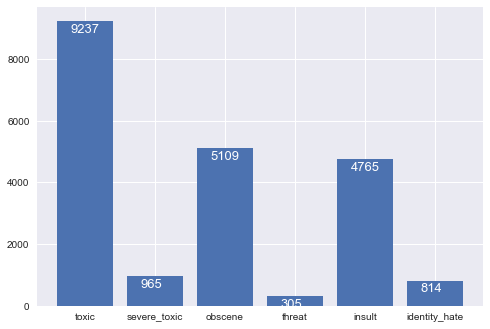

In [8]:
classes = list(data.columns[2:])
classes_count = [sum(data[data_class] == 1) for data_class in classes]
plt.bar(range(len(classes)), classes_count)
plt.xticks(range(len(classes)), classes)
for i in range(len(classes)):
    plt.text(-0.2 + i, classes_count[i] - 370, classes_count[i], color='white', fontsize=13)
plt.show()

In [9]:
sum(classes_count)

21195

In [10]:
data[data.severe_toxic==1].index

Int64Index([  213,   480,   721,   811,   869,  1223,  1563,  1695,  1703,
             1744,
            ...
            94807, 94815, 94895, 94960, 95070, 95091, 95108, 95220, 95269,
            95394],
           dtype='int64', length=965)

In [11]:
data[data.severe_toxic==1].comment_text[:20]

213     F'UCK YOU ADMINISTRATORS (I WILL BE BACK TO TR...
480     AH HAAHHAHAHAH YAAA BITCH YAAAA!@!!!!!!AH HAAH...
721     FROZEN SUCKS LION KING IS THE BESTFROZEN SUCKS...
811                     This user is a fucking douche bag
869     fuck  \n\n62.158.73.165  62.158.73.165  62.158...
1223    Fuck you \n\nYou suck. Leave me alone. Fuck ti...
1563    I am going to shoot you in the head and laugh ...
1695    you're a dirty faggot \n\nlick my hairy nut sa...
1703    Stop being a shithead, or I will rip off your ...
1744    and why the fuck you say fuck you up there? fu...
1916    Fuck Wikipedia and fuck all the leftist, liber...
1951    stop reverting my edit\nyour so fucken gay get...
2030    SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...
2263    Are you a fucking dick-head?  People like you ...
2484    Fuck you Orange Suede Sof \n\nFuck you Orange ...
2492    Hello \n\ngo fuck yourself, kid.  Adults are t...
2592    Fuck you you stupid and gay bastard who thinls...
2675    You ca

In [12]:
data[data.toxic==1].comment_text[:20]

0      Nonsense?  kiss off, geek. what I said is true...
20     Why hasn't Alitalia been removed rom the allia...
26     "\nThe Graceful Slick....\nIs non other than a...
30     "\n\n Stupid? \n\nAs soon as I saw the phrase ...
32     "\nBan one side of an argument by a bullshit n...
39                           Are you gay?? Sound like it
62     and in the program on last night Crime Museum:...
79     "\n\nI didn't call you a ""biased backward yan...
81     "\n\nIt was very constructive you are just ver...
86     "\n\n You know what? Fuck you! I tried to be c...
89     HE THINKS THEY ARE COPYRIGHT VIOLATION. PITY H...
104    "\n\n Corrected spelling of ""recognised"" to ...
120    "\n\nWow, you're a little touchy aren't you? Y...
124                         YOU NEED A PUSSY, YOUR GEEK!
144    COINCIDENCE? \n\nHave you noticed that in ever...
149    For the last time, Turkish people ARE NOT WHIT...
160    loser, get a life\n\nyou must be fat, ugly and...
213    F'UCK YOU ADMINISTRATORS

In [13]:
data[data.identity_hate==1].comment_text[:20]

308     These Iranian bastards are at it again. Not on...
571     "\n\n The Great One! \nI dont really have a pr...
595     probably that you are a german... fucking germ...
889     "\n\n Contested deletion \n\nThis page should ...
1013    Also, it's well known that slavic women don't ...
1015    How can you defend those barbarian invaders? \...
1172    i think this som bitch is fuckin nuts...i mean...
1916    Fuck Wikipedia and fuck all the leftist, liber...
1951    stop reverting my edit\nyour so fucken gay get...
2111    He IS in Gay German Nazi Faggots. Please do no...
2187    If you guys really discuss napoleon you need t...
2297    Suck it!!! Asyou're used to do,ignorant Romani...
2322                LOL \n\nStop eating shit you nigger!!
2467    Swedes are the racist trolls. They support the...
2592    Fuck you you stupid and gay bastard who thinls...
2776       MATE, are you jewish?\n\nGayness is in the air
2798    NIGHTSTALLIONS FIANCE GOT FUCKED BY A NIGGER A...
2817    What a

In [14]:
sum(data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate==0)

86061

In [15]:
9790 + 86061, data.shape

(95851, (95851, 8))

In [16]:
sum(data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate>1)

5957

In [17]:
data[data.toxic + data.severe_toxic + data.obscene + data.threat + data.insult + data.identity_hate>1].shape

(5957, 8)

In [18]:
def get_intersect():
    arrays_intersect = []
    for class_name in classes:
        current_intersect = []
        for class_name_2 in classes:
            if class_name_2 == class_name:
                continue
            current_intersect += [data[data.loc[:, class_name] + data.loc[:, class_name_2] > 1].shape[0]]
        arrays_intersect.append(current_intersect)
    return arrays_intersect
classes_intersect = get_intersect()

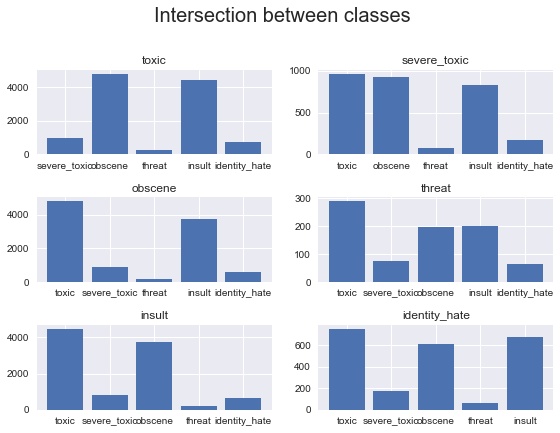

In [19]:
fig, ax_arr = plt.subplots(ncols=2, nrows=int(len(classes_intersect)/2))
plt.suptitle("Intersection between classes", y = 1.09, fontsize=20)
for i in range(len(classes)):
    ax_arr[i//2, i%2].bar(range(len(classes_intersect[i])), classes_intersect[i])
    ax_arr[i//2, i%2].set_title(classes[i])
    l = list(np.delete(classes[:], i))
    l = [0] + l
    ax_arr[i//2, i%2].set_xticklabels(l)
plt.tight_layout()
plt.show()

### Building the model

In [20]:
def review_to_wordlist( review, remove_stopwords=False ):

#     review_text = BeautifulSoup(review).get_text()
   
    review_text = re.sub("[^a-zA-Z]"," ", str(review))
   
    words = review_text.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    return(words)


In [21]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences( review, tokenizer, remove_stopwords=False ):
  
    raw_sentences = tokenizer.tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    
    return sentences

In [22]:
data_array = np.array(data)  #convert array to numpy type array

data_train ,data_valid = train_test_split(data_array,test_size=0.2)  

In [23]:
data_train.shape, data_valid.shape

((76680, 8), (19171, 8))

In [24]:
data_train[:3, 3]

array([0, 0, 0], dtype=object)

In [25]:
print(sum(data_train[:, 2] ==1)/sum(data.iloc[:, 2] == 1), sum(data_valid[:, 2] ==1)/sum(data.iloc[:, 2] == 1))
print(sum(data_train[:, 3] ==1)/sum(data.iloc[:, 3] == 1), sum(data_valid[:, 3] ==1)/sum(data.iloc[:, 3] == 1))
print(sum(data_train[:, 4] ==1)/sum(data.iloc[:, 4] == 1), sum(data_valid[:, 4] ==1)/sum(data.iloc[:, 4] == 1))
print(sum(data_train[:, 5] ==1)/sum(data.iloc[:, 5] == 1), sum(data_valid[:, 5] ==1)/sum(data.iloc[:, 5] == 1))
print(sum(data_train[:, 6] ==1)/sum(data.iloc[:, 6] == 1), sum(data_valid[:, 6] ==1)/sum(data.iloc[:, 6] == 1))
print(sum(data_train[:, 7] ==1)/sum(data.iloc[:, 7] == 1), sum(data_valid[:, 7] ==1)/sum(data.iloc[:, 7] == 1))

0.805564577244 0.194435422756
0.79170984456 0.20829015544
0.806615776081 0.193384223919
0.786885245902 0.213114754098
0.80314795383 0.19685204617
0.808353808354 0.191646191646


In [26]:
sentences = [] 

print("Parsing sentences from training set")
for review in data_train[:, 1]:
    sentences += review_to_sentences(review, tokenizer)

print("Parsing sentences from unlabeled set")
for review in data_valid[:, 1]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set
Parsing sentences from unlabeled set


In [27]:
len(sentences)

424423

In [28]:
sentences[0]

['he', 'was', 'black', 'italic', 'text']

In [29]:
sentences[1]

['some',
 'of',
 'the',
 'people',
 'places',
 'or',
 'things',
 'you',
 'have',
 'written',
 'about',
 'may',
 'not',
 'be',
 'sufficiently',
 'well',
 'known',
 'to',
 'merit',
 'articles',
 'of',
 'their',
 'own']

In [30]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [46]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)



# Initialize and train the model (this will take some time)

print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2017-12-23 16:13:01,250 : INFO : collecting all words and their counts
2017-12-23 16:13:01,251 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-23 16:13:01,289 : INFO : PROGRESS: at sentence #10000, processed 153065 words, keeping 13685 word types
2017-12-23 16:13:01,332 : INFO : PROGRESS: at sentence #20000, processed 306679 words, keeping 20907 word types
2017-12-23 16:13:01,374 : INFO : PROGRESS: at sentence #30000, processed 450862 words, keeping 26336 word types
2017-12-23 16:13:01,416 : INFO : PROGRESS: at sentence #40000, processed 608277 words, keeping 31266 word types


Training model...


2017-12-23 16:13:01,460 : INFO : PROGRESS: at sentence #50000, processed 764851 words, keeping 35642 word types
2017-12-23 16:13:01,502 : INFO : PROGRESS: at sentence #60000, processed 920122 words, keeping 39662 word types
2017-12-23 16:13:01,546 : INFO : PROGRESS: at sentence #70000, processed 1074872 words, keeping 43542 word types
2017-12-23 16:13:01,592 : INFO : PROGRESS: at sentence #80000, processed 1231415 words, keeping 47522 word types
2017-12-23 16:13:01,634 : INFO : PROGRESS: at sentence #90000, processed 1383058 words, keeping 50850 word types
2017-12-23 16:13:01,684 : INFO : PROGRESS: at sentence #100000, processed 1542999 words, keeping 54252 word types
2017-12-23 16:13:01,729 : INFO : PROGRESS: at sentence #110000, processed 1694363 words, keeping 57417 word types
2017-12-23 16:13:01,769 : INFO : PROGRESS: at sentence #120000, processed 1835603 words, keeping 60246 word types
2017-12-23 16:13:01,811 : INFO : PROGRESS: at sentence #130000, processed 1988153 words, keepin

In [47]:
model.syn0_lockf.shape

(7928,)

In [48]:
model['he']

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


array([ 0.00755183, -0.0237998 , -0.119234  ,  0.04472408, -0.05962428,
        0.00220911,  0.02842643, -0.0110237 , -0.06125546,  0.03542334,
       -0.01479588,  0.03279963, -0.05294646, -0.07037295,  0.05067915,
        0.10604518, -0.03859404,  0.08926969,  0.01185556, -0.05778293,
       -0.07302342, -0.07048602, -0.06215798, -0.05763784,  0.06365775,
        0.11505347, -0.09744398, -0.0609575 , -0.03519806,  0.02786094,
        0.03359922, -0.02064945, -0.00982771, -0.04410329,  0.02345378,
        0.0102284 ,  0.05238913,  0.03977534,  0.02010577,  0.01410025,
        0.0609512 , -0.05892008, -0.00663022,  0.05530287,  0.09666941,
        0.05683028, -0.03143321, -0.04705799,  0.0563247 ,  0.10170096,
        0.04170763, -0.0310665 , -0.04988116, -0.04965904,  0.06281916,
        0.04297115,  0.16508695,  0.04473774,  0.07236359,  0.02479101,
       -0.00616275, -0.08847532, -0.07477806, -0.00678895, -0.07413031,
        0.03245664,  0.04418996,  0.00558636,  0.07073478, -0.11

In [31]:
model = gensim.models.Word2Vec.load('300features_40minwords_10context')

In [32]:
def makeFeatureVec(words, model, num_features):
    
    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0.
 
    index2word_set = set(model.wv.index2word)
    
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
   
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
  
    counter = 0
  
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    for review in reviews:
        
        if counter%1000 == 0:
            print("Review %d of %d" % (counter, len(reviews)))
      
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        
        counter = counter + 1
        
    return reviewFeatureVecs

In [33]:
clean_train_reviews = []
for review in data_train[:, 1]:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))

trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

print("Creating average feature vecs for test reviews")
clean_valid_reviews = []
for review in data_valid[:, 1]:
    clean_valid_reviews.append(review_to_wordlist(review, remove_stopwords=True))

validDataVecs = getAvgFeatureVecs( clean_valid_reviews, model, num_features)

Review 0 of 76680


/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 76680
Review 2000 of 76680
Review 3000 of 76680
Review 4000 of 76680
Review 5000 of 76680
Review 6000 of 76680
Review 7000 of 76680
Review 8000 of 76680
Review 9000 of 76680
Review 10000 of 76680
Review 11000 of 76680
Review 12000 of 76680
Review 13000 of 76680
Review 14000 of 76680
Review 15000 of 76680
Review 16000 of 76680
Review 17000 of 76680
Review 18000 of 76680
Review 19000 of 76680
Review 20000 of 76680
Review 21000 of 76680
Review 22000 of 76680
Review 23000 of 76680
Review 24000 of 76680
Review 25000 of 76680
Review 26000 of 76680
Review 27000 of 76680
Review 28000 of 76680
Review 29000 of 76680
Review 30000 of 76680
Review 31000 of 76680
Review 32000 of 76680
Review 33000 of 76680
Review 34000 of 76680
Review 35000 of 76680
Review 36000 of 76680
Review 37000 of 76680
Review 38000 of 76680
Review 39000 of 76680
Review 40000 of 76680
Review 41000 of 76680
Review 42000 of 76680
Review 43000 of 76680
Review 44000 of 76680
Review 45000 of 76680
Review 46000 of 766

In [34]:
trainDataVecs[1].shape

(300,)

In [35]:
np.any(np.isnan(trainDataVecs))

True

In [36]:
trainDataVecs[np.isnan(trainDataVecs)] = 0

In [37]:
np.any(np.isnan(validDataVecs))

True

In [38]:
validDataVecs[np.isnan(validDataVecs)] = 0

#### prepare the test data

In [39]:
sum(test_data.iloc[:, 1]=='')

0

In [40]:
clean_test_reviews = []
for review in test_data.iloc[:, 1]:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

Review 0 of 226998


/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 226998
Review 2000 of 226998
Review 3000 of 226998
Review 4000 of 226998
Review 5000 of 226998
Review 6000 of 226998
Review 7000 of 226998
Review 8000 of 226998
Review 9000 of 226998
Review 10000 of 226998
Review 11000 of 226998
Review 12000 of 226998
Review 13000 of 226998
Review 14000 of 226998
Review 15000 of 226998
Review 16000 of 226998
Review 17000 of 226998
Review 18000 of 226998
Review 19000 of 226998
Review 20000 of 226998
Review 21000 of 226998
Review 22000 of 226998
Review 23000 of 226998
Review 24000 of 226998
Review 25000 of 226998
Review 26000 of 226998
Review 27000 of 226998
Review 28000 of 226998
Review 29000 of 226998
Review 30000 of 226998
Review 31000 of 226998
Review 32000 of 226998
Review 33000 of 226998
Review 34000 of 226998
Review 35000 of 226998
Review 36000 of 226998
Review 37000 of 226998
Review 38000 of 226998
Review 39000 of 226998
Review 40000 of 226998
Review 41000 of 226998
Review 42000 of 226998
Review 43000 of 226998
Review 44000 of 2269

In [44]:
np.any(np.isnan(testDataVecs))

False

In [45]:
testDataVecs[np.isnan(testDataVecs)] = 0

In [46]:
np.any(np.isnan(testDataVecs))

False

#### Build NN model

In [149]:
def build_nn_model():
#     ad_optimizer = optimizers.Adam(clipnorm=1., lr=0.3)
    model = Sequential()
    model.add(Dense(6, input_dim=num_features, activation='tanh'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
nn_model = build_nn_model()

In [57]:
nn_model.fit(trainDataVecs, data_train[:, 2].astype(int), nb_epoch=100, batch_size=64)

Epoch 1/100
76680/76680 [==============================] - 0s - loss: 0.1987 - acc: 0.9319     
Epoch 2/100
76680/76680 [==============================] - 0s - loss: 0.1506 - acc: 0.9430     
Epoch 3/100
76680/76680 [==============================] - 0s - loss: 0.1472 - acc: 0.9447     
Epoch 4/100
76680/76680 [==============================] - 0s - loss: 0.1455 - acc: 0.9452     
Epoch 5/100
76680/76680 [==============================] - 0s - loss: 0.1443 - acc: 0.9453     
Epoch 6/100
76680/76680 [==============================] - 0s - loss: 0.1436 - acc: 0.9457     
Epoch 7/100
76680/76680 [==============================] - 0s - loss: 0.1430 - acc: 0.9460     
Epoch 8/100
76680/76680 [==============================] - 0s - loss: 0.1422 - acc: 0.9460     
Epoch 9/100
76680/76680 [==============================] - 0s - loss: 0.1414 - acc: 0.9462     
Epoch 10/100
76680/76680 [==============================] - 0s - loss: 0.1409 - acc: 0.9467     
Epoch 11/100
76680/76680 [=============

In [58]:
score = nn_model.evaluate(trainDataVecs, data_train[:, 2].astype(int), batch_size=32)
score

75936/76680 [============================>.] - ETA: 0s

[0.12120002333889048, 0.9546948356807512]

In [60]:
score = nn_model.evaluate(validDataVecs, data_valid[:, 2].astype(int), batch_size=64)
score

15936/19171 [=======================>......] - ETA: 0s

[0.13797402020929925, 0.95075895885341477]

In [61]:
preds1 = nn_model.predict_proba(testDataVecs)

219104/226998 [===========================>..] - ETA: 0s

In [62]:
preds1

array([[ 0.00092868],
       [ 0.0013055 ],
       [ 0.00160392],
       ..., 
       [ 0.00672257],
       [ 0.00170642],
       [ 0.00437022]], dtype=float32)

In [63]:
sum(np.isnan(preds1))

array([0])

In [150]:
preds = []
for i in range(2, 8):
    nn_model_col = build_nn_model()
    nn_model_col.fit(trainDataVecs, data_train[:, i].astype(int), nb_epoch=100, batch_size=64)
    preds_col = nn_model_col.predict_proba(testDataVecs)
    preds.append(preds_col)

Epoch 1/100
76680/76680 [==============================] - 1s - loss: 0.2191 - acc: 0.9279     
Epoch 2/100
76680/76680 [==============================] - 0s - loss: 0.1507 - acc: 0.9436     
Epoch 3/100
76680/76680 [==============================] - 0s - loss: 0.1475 - acc: 0.9444     
Epoch 4/100
76680/76680 [==============================] - 1s - loss: 0.1455 - acc: 0.9450     
Epoch 5/100
76680/76680 [==============================] - 0s - loss: 0.1443 - acc: 0.9452     
Epoch 6/100
76680/76680 [==============================] - 1s - loss: 0.1432 - acc: 0.9458     
Epoch 7/100
76680/76680 [==============================] - 2s - loss: 0.1425 - acc: 0.9453     
Epoch 8/100
76680/76680 [==============================] - 3s - loss: 0.1419 - acc: 0.9456     
Epoch 9/100
76680/76680 [==============================] - 3s - loss: 0.1415 - acc: 0.9460     
Epoch 10/100
76680/76680 [==============================] - 1s - loss: 0.1410 - acc: 0.9461     
Epoch 11/100
76680/76680 [=============

In [69]:
len(preds)

6

In [70]:
preds

[array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=float32), array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=float32), array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=float32), array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=float32), array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=float32), array([[ 0.00092868],
        [ 0.0013055 ],
        [ 0.00160392],
        ..., 
        [ 0.00672257],
        [ 0.00170642],
        [ 0.00437022]], dtype=f

In [76]:
list(preds[0].reshape(-1))

[0.00092868123,
 0.0013055028,
 0.0016039159,
 0.0053261793,
 0.0082362574,
 0.0042188037,
 0.00046883323,
 0.008981863,
 0.00038316575,
 0.0014333342,
 0.00032618409,
 0.060730528,
 0.10396533,
 0.00083693763,
 0.16167924,
 0.0065378835,
 0.0013064755,
 0.041894995,
 0.00044829401,
 0.027719274,
 0.63852429,
 0.0053703953,
 0.0048807366,
 0.016028071,
 0.17519397,
 8.722832e-05,
 0.00087378005,
 0.014160906,
 1.1549428e-05,
 0.011034016,
 4.3363219e-05,
 0.00071047869,
 0.006599871,
 0.75729984,
 0.00079978484,
 0.061450407,
 0.10396533,
 0.0002222529,
 0.0038070306,
 0.0012209133,
 0.0015237827,
 0.10396533,
 0.014196377,
 0.0003549493,
 0.0088825691,
 0.0012906719,
 0.0021035261,
 0.10396533,
 0.037681501,
 0.0018901028,
 0.00016360145,
 0.00049982418,
 0.0034200524,
 0.10396533,
 0.0059615686,
 0.0013220236,
 0.34625867,
 0.00036115063,
 0.95104641,
 0.0058751586,
 0.00076318829,
 0.0019280822,
 8.4442647e-05,
 0.012385482,
 0.0099369772,
 0.31234282,
 0.051092595,
 0.61626655,
 0.

In [151]:
d = {'id': test_data.id, 'toxic': list(preds[0].reshape(-1)),\
     'severe_toxic':  list(preds[1].reshape(-1)), 'obscene': list(preds[2].reshape(-1)),\
     'threat': list(preds[3].reshape(-1)), 'insult': list(preds[4].reshape(-1)),\
     'identity_hate': list(preds[5].reshape(-1))}
toSubmit = pd.DataFrame(d)

In [152]:
toSubmit.to_csv('./../submissions/submit1.csv', index=False)

#### Build Random Forest Classifier

In [71]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(trainDataVecs, data_train[:, 2].astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
preds_clf_1 = clf.predict(validDataVecs)

In [73]:
confusion_matrix(data_valid[:, 2].astype(int), preds_clf_1)

array([[17138,   120],
       [  993,   920]])

In [74]:
accuracy_score(data_valid[:, 2].astype(int), preds_clf_1)

0.94194356058630224

#### Build the bag of words model

In [147]:
def review_to_words( raw_review ):
  
    review_text = BeautifulSoup(str(raw_review)).get_text() 
          
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    words = letters_only.lower().split()                             
   
    stops = set(stopwords.words("english"))                  
    
    meaningful_words = [w for w in words if not w in stops]   
   
    return( " ".join( meaningful_words ))

In [60]:
clean_train_reviews_bow = []
for review in data_train[:, 1]:
    clean_train_reviews_bow.append(review_to_words(review))

/Users/apple/anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/apple/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/Users/apple/anaconda/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Be

In [61]:
clean_valid_reviews_bow = []
for review in data_valid[:, 1]:
    clean_valid_reviews_bow.append(review_to_words(review))

/Users/apple/anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/apple/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [110]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) 
train_data_features = vectorizer.fit_transform(clean_train_reviews_bow)
train_data_features = train_data_features.toarray()

In [111]:
valid_data_features = vectorizer.transform(clean_valid_reviews_bow)
valid_data_features = valid_data_features.toarray()

In [148]:
clean_test_reviews_bow = []
for review in test_data.iloc[:, 1]:
    clean_test_reviews_bow.append(review_to_words(review))
test_data_features = vectorizer.transform(clean_test_reviews_bow)
test_data_features = test_data_features.toarray()

/Users/apple/anaconda/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/apple/anaconda/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/Users/apple/anaconda/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decode

In [93]:
forest_bow = RandomForestClassifier(n_estimators = 100) 
forest_bow.fit(train_data_features, data_train[:, 2].astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
preds_forest_bow_1 = forest_bow.predict(valid_data_features)

In [95]:
confusion_matrix(data_valid[:, 2].astype(int), preds_forest_bow_1)

array([[16925,   333],
       [  857,  1056]])

In [96]:
accuracy_score(data_valid[:, 2].astype(int), preds_forest_bow_1)

0.93792707735642378

#### nn for bow

In [128]:
def build_nn_model2():
    model = Sequential()
    model.add(Dense(6, input_dim=10000, activation='tanh'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [142]:
nn_model_bow = build_nn_model2()
nn_model_bow.fit(train_data_features, data_train[:, 2].astype(int), nb_epoch=3, batch_size=64)

Epoch 1/3
76680/76680 [==============================] - 4s - loss: 0.2294 - acc: 0.9281     
Epoch 2/3
76680/76680 [==============================] - 4s - loss: 0.1294 - acc: 0.9593     
Epoch 3/3
76680/76680 [==============================] - 4s - loss: 0.1055 - acc: 0.9646     


In [143]:
score = nn_model_bow.evaluate(train_data_features, data_train[:, 2].astype(int), batch_size=64)
score

75712/76680 [============================>.] - ETA: 0s

[0.06912601746892752, 0.97556077203964531]

In [144]:
score = nn_model_bow.evaluate(valid_data_features, data_valid[:, 2].astype(int), batch_size=64)
score

19171/19171 [==============================] - 0s     


[0.18272877798696172, 0.95336706484373324]

In [153]:
preds2 = []
for i in range(2, 8):
    nn_model_col = build_nn_model2()
    nn_model_col.fit(train_data_features, data_train[:, i].astype(int), nb_epoch=3, batch_size=64)
    preds_col = nn_model_col.predict_proba(test_data_features)
    preds2.append(preds_col)

Epoch 1/3
76680/76680 [==============================] - 7s - loss: 0.2268 - acc: 0.9291     
Epoch 2/3
76680/76680 [==============================] - 4s - loss: 0.1261 - acc: 0.9599     
Epoch 3/3
76680/76680 [==============================] - 9s - loss: 0.0738 - acc: 0.9857     
Epoch 2/3
76680/76680 [==============================] - 4s - loss: 0.0316 - acc: 0.9903     
Epoch 3/3
76680/76680 [==============================] - 9s - loss: 0.1601 - acc: 0.9547     
Epoch 2/3
76680/76680 [==============================] - 3s - loss: 0.0750 - acc: 0.9789     
Epoch 3/3
76680/76680 [==============================] - 10s - loss: 0.0494 - acc: 0.9930    
Epoch 2/3
76680/76680 [==============================] - 4s - loss: 0.0147 - acc: 0.9968     
Epoch 3/3
76680/76680 [==============================] - 11s - loss: 0.1570 - acc: 0.9573    
Epoch 2/3
76680/76680 [==============================] - 4s - loss: 0.0866 - acc: 0.9710     
Epoch 3/3
76680/76680 [==============================] - 10s

In [154]:
d = {'id': test_data.id, 'toxic': list(preds2[0].reshape(-1)),\
     'severe_toxic':  list(preds2[1].reshape(-1)), 'obscene': list(preds2[2].reshape(-1)),\
     'threat': list(preds2[3].reshape(-1)), 'insult': list(preds2[4].reshape(-1)),\
     'identity_hate': list(preds2[5].reshape(-1))}
toSubmit = pd.DataFrame(d)

In [155]:
toSubmit.to_csv('./../submissions/submit2.csv', index=False)

#### tf idf

In [47]:
tfvectorizer = TfidfVectorizer(stop_words='english', max_features=50000)

In [48]:
tf_train = tfvectorizer.fit_transform(data_train[:, 1])

In [49]:
tf_valid = tfvectorizer.transform(data_valid[:, 1])

In [50]:
tf_train.shape

(76680, 50000)

In [51]:
def build_nn_model3():
    model = Sequential()
    model.add(Dense(200, input_dim=50000, activation='tanh'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [52]:
model_3 = build_nn_model3()
model_3.fit(tf_train.toarray(), data_train[:, 2].astype(int), nb_epoch=2, batch_size=64)

Epoch 1/2
76680/76680 [==============================] - 199s - loss: 0.2149 - acc: 0.9337   
Epoch 2/2
76680/76680 [==============================] - 337s - loss: 0.1079 - acc: 0.9637   


In [53]:
score = model_3.evaluate(tf_valid.toarray(), data_valid[:, 2].astype(int), batch_size=64)
score

19171/19171 [==============================] - 10s    


[0.15321871035714693, 0.95587084659120547]

In [54]:
model_3.save('model_3.h5')